In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip =tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir =os.path.join(PATH, 'train')
val_dir =os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE =(160, 160)

train_dataset =tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [7]:
validation_dataset =tf.keras.utils.image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


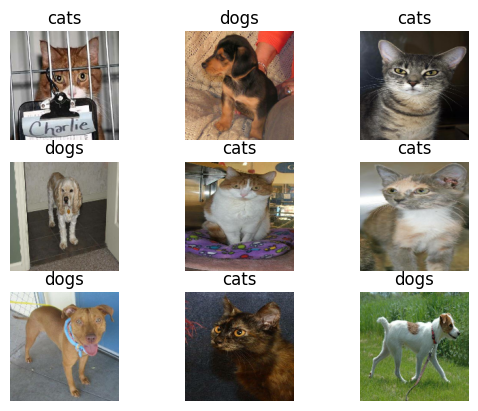

In [9]:
# visualizing the data
class_names = train_dataset.class_names

plt.figure(figsize=(8,8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i +1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

# print("val Batch size: %d")

In [11]:
from tensorflow._api.v2.data.experimental import AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE
train_dataset =train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset =validation_dataset.prefetch(buffer_size=AUTOTUNE)



In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

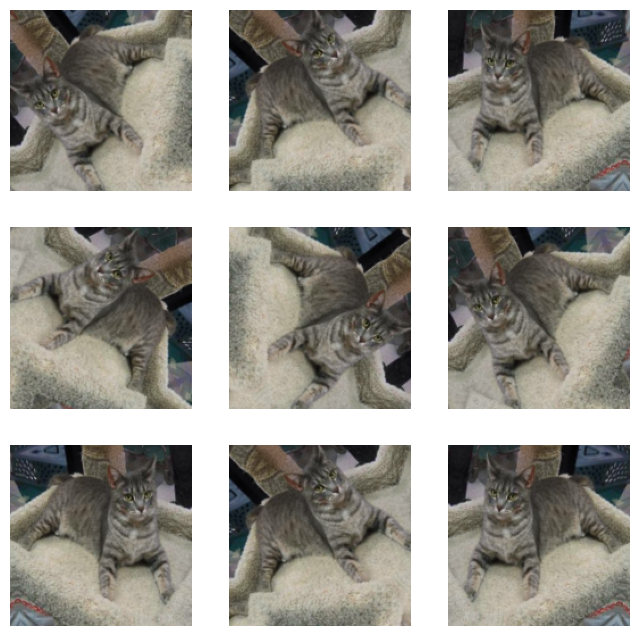

In [15]:
plt.figure(figsize=(8, 8))
for images, _ in train_dataset.take(1):
 for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch =base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [44]:
base_model.trainable=True
fine_tune_at = 100

In [42]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False


In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [48]:
inputs = tf.keras.layers.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x =preprocess_input(x)
x = base_model(x, training= False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

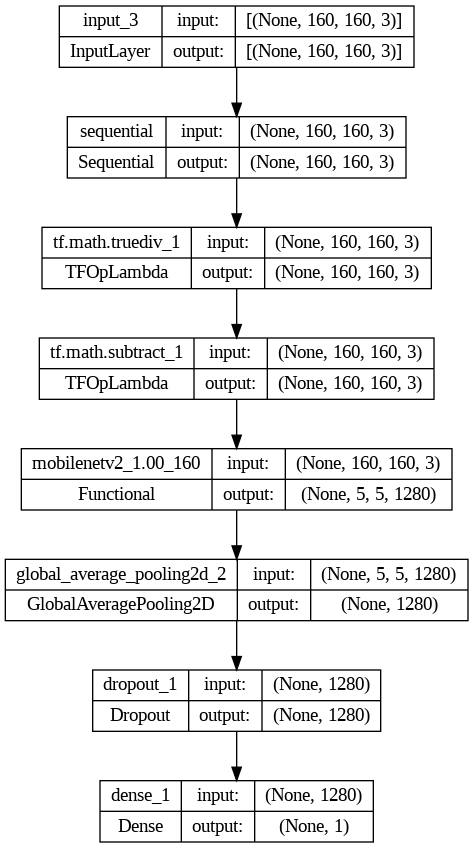

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10))

In [39]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics =[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')] )

In [40]:
model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 105ms/step - loss: 0.6970 - accuracy: 0.5860 - val_loss: 0.5332 - val_accuracy: 0.7512
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.5252 - accuracy: 0.7500 - val_loss: 0.3904 - val_accuracy: 0.8577
Epoch 3/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4174 - accuracy: 0.8230 - val_loss: 0.3083 - val_accuracy: 0.9084
Epoch 4/10
63/63 [==============================] - 5s 64ms/step - loss: 0.3548 - accuracy: 0.8565 - val_loss: 0.2463 - val_accuracy: 0.9369
Epoch 5/10
63/63 [==============================] - 4s 56ms/step - loss: 0.3001 - accuracy: 0.8905 - val_loss: 0.2130 - val_accuracy: 0.9493
Epoch 6/10
63/63 [==============================] - 5s 79ms/step - loss: 0.2784 - accuracy: 0.9005 - val_loss: 0.1866 - val_accuracy: 0.9567
Epoch 7/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2647 - accuracy: 0.8955 - val_loss: 0.1689 - val_accuracy: 0.9629
Epoch 8/10


In [53]:
# accuracy = model.history["accuracy"]
# val_accuracy = model.history["val_accuracy"]
# loss = model.history["loss"]
# val_loss = model.history["val_loss"]
# epochs = range(1, len(accuracy) + 1)
# plt.plot(epochs, accuracy, "bo", label="Training accuracy")
# plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
# plt.title("Training and validation accuracy")
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training loss")
# plt.plot(epochs, val_loss, "b", label="Validation loss")
# plt.title("Training and validation loss")
# plt.legend()
# plt.show()

In [ ]:
image_batch, label_batch = test_dataset.as_numpy.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf